In [233]:
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import ast
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import os
from tqdm import tqdm_notebook
import glob
import sklearn.utils
import math

In [441]:
def draw_cv2(raw_strokes, size=256, lw=2, time_color=True, center = True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    color_step = int(200 / len(raw_strokes))
    for t, stroke in enumerate(raw_strokes):
        color = 255 - color_step * t if time_color else 255
#         print(color)
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        img = cv2.resize(img, (size, size))
        
#     if center:
#         img = pad_center(img, size)
        
    return img

In [198]:
def draw_cv2_pointcnts(raw_strokes, size=256, lw=2):
    points_cnt = [len(s[0]) for s in raw_strokes]
    min_cnt = min(points_cnt)
    max_cnt = max(points_cnt)
    if max_cnt > min_cnt:
        color_step = (200 / (max_cnt - min_cnt))
    else:
        color_step = 0
#     print(max_cnt, min_cnt, color_step)
    
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    
    for t, stroke in enumerate(raw_strokes):
        if color_step > 0:
            color = 255 - int(color_step * (max_cnt - len(stroke[0])))
            #print(color, color_step, len(stroke[0]), (len(stroke[0]) - min_cnt))
        else:
            color = 255
        
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

In [235]:
def get_line_length(stroke):
    length = 0
    for i in range(len(stroke[0]) - 1):
        x = stroke[0][i + 1] - stroke[0][i]
        y = stroke[1][i + 1] - stroke[1][i]
        step_length = (x**2 + y**2) **(1/2)
#         print(step_length)
        length += step_length
    return int(length)

def draw_cv2_linelength(raw_strokes, size=256, lw=2):
    lengths = [get_line_length(s) for s in raw_strokes]
    min_length = min(lengths)
    max_length = max(lengths)
    if max_length > min_length:
        color_step = 200 / (max_length - min_length)
    else:
        color_step = 0
#     print(max_cnt, min_cnt, color_step)
    
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    
    for t, stroke in enumerate(raw_strokes):
        if color_step > 0:
            color = 255 - int(color_step * (max_length - get_line_length(stroke)))
#             print(color, color_step, get_line_length(stroke))
        else:
            color = 255
        
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

In [224]:
def draw_cv2_whole(raw_strokes, size=256, lw=2):
    img = np.zeros((BASE_SIZE, BASE_SIZE, 3), np.uint8)
    img[..., 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=True)
    img[..., 1] = draw_cv2_pointcnts(stroke, size=size, lw=lw)
    img[..., 2] = draw_cv2_linelength(stroke, size=size, lw=lw)
    
    return img

In [475]:
def draw_cv2_parts(raw_strokes, size=256, lw=2, center = True):
    img = np.zeros((size, size, 3), np.uint8)
    img[..., 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=True, center = center)
    
    lengths = [get_line_length(s) for s in raw_strokes]
    mean_length = np.mean(np.array(lengths))
    point_cnts = [len(s[0]) for s in raw_strokes]
    mean_pcnts = np.mean(np.array(point_cnts))
    
    outlines = []
    details = []
    for s in raw_strokes:
        if get_line_length(s) < mean_length or len(s[0]) < mean_pcnts:
            details.append(s)
        else:
            outlines.append(s)
        
    img[..., 1] = draw_cv2(outlines, size=size, time_color = False, center = center)
    if len(details) > 0:
        img[..., 2] = draw_cv2(details, size=size, time_color = False, center = center)
    
    return img

In [615]:
def draw_cv2_parts_opt(raw_strokes, size=256, lw=2, center = True):
    img = np.zeros((BASE_SIZE, BASE_SIZE, 3), np.uint8)
    
    lengths = np.array([get_line_length(s) for s in raw_strokes])
    mean_length = int(np.mean(lengths))
    
    point_cnts = np.array([len(s[0]) for s in raw_strokes])
    mean_pcnts = int(np.mean(point_cnts))
    
    cnt_stroke = len(raw_strokes)
    
    
    not_one_stroke = cnt_stroke > 1 and np.any(lengths != lengths[0])
    print(not_one_stroke)
    if not_one_stroke:
        outlines = []
        details = []
        for idx,s in enumerate(raw_strokes):
            line_length = get_line_length(s)
            line_ptr = len(s[0])
            if line_length < mean_length or line_ptr < mean_pcnts:
                details.append(line_length)
            else:
                outlines.append(line_length)

        details = np.array(details)
        outlines = np.array(outlines)
        
        print('outline', outlines)
        print('details', details)

        max_outline = np.max(outlines)
        min_outline = np.min(outlines)
        len_outline = (max_outline - min_outline) if len(outlines) > 1 else max_outline

        if len(details) > 0:
            max_detail = np.max(details)
            min_detail = np.min(details)
            len_detail = (max_detail - min_detail) if len(details) > 1 else max_detail
            len_detail = 1 if len_detail == 0 else len_detail
        else:
            max_detail = 0
            min_detail = 0
            len_detail = 1
#         print(len(raw_strokes), len_outline, len_detail)

    color_step = int(200 / cnt_stroke)
    for idx,s in enumerate(raw_strokes):
        color_r = 255 - color_step * idx
        
        if not_one_stroke:
            line_length = get_line_length(s)
            line_ptr = len(s[0])
            if line_length < mean_length or line_ptr < mean_pcnts:
                color_g = 0
                color_b = int(200 * (1 - (max_detail - line_length) / len_detail)) + 55
            else:
                color_g = int(200 * (1 - (max_outline - line_length) / len_outline)) + 55
                color_b = 0
        else:
            color_g = 255
            color_b = 0
        
        color = (color_r, color_g, color_b)
#         print(color)
        for i in range(len(s[0]) - 1):
            _ = cv2.line(img, (s[0][i], s[1][i]),
                             (s[0][i + 1], s[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        img = cv2.resize(img, (size, size))
        
    return img

In [465]:
def draw_cv2_parts_threshold(raw_strokes, size=256, lw=2, center = False, detail_threshold = 9):
    img = np.zeros((size, size, 3), np.uint8)
    img[..., 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=True, center = center)
    
    if len(raw_strokes) >= detail_threshold:
        lengths = [get_line_length(s) for s in raw_strokes]
        mean_length = np.mean(np.array(lengths))
        point_cnts = [len(s[0]) for s in raw_strokes]
        mean_pcnts = np.mean(np.array(point_cnts))
 
        outlines = []
        details = []
        for s in raw_strokes:
            if get_line_length(s) < mean_length or len(s[0]) < mean_pcnts:
                details.append(s)
            else:
                outlines.append(s)

        img[..., 1] = draw_cv2(outlines, size=size, time_color = False, center = center)
        if len(details) > 0:
            img[..., 2] = draw_cv2(details, size=size, time_color = False, center = center)
    else:
        img[..., 1] = draw_cv2(raw_strokes, size=size, time_color = False, center = center)
    
    return img

In [619]:
test = np.array([158,158])
np.all(test == test[0])

True

In [236]:
BASE_SIZE = 256

In [458]:
train = pd.read_csv('../input/train_simp/angel.csv')
train.drawing = train.drawing.apply(json.loads)
train['num_strokes'] = train.drawing.apply(len)

In [462]:
(train['num_strokes'] < 10).sum() / len(train)

0.7409640968103863

In [600]:
%%time
for i in range(1000):
    img = draw_cv2_parts(stroke)

# fig, axs = plt.subplots(1, 4, figsize = (10, 10))
# axs[0].imshow(img[...,0])
# axs[1].imshow(img[...,1])
# axs[2].imshow(img[...,2])
# axs[3].imshow(img)

CPU times: user 448 ms, sys: 0 ns, total: 448 ms
Wall time: 448 ms


True
CPU times: user 48 ms, sys: 4 ms, total: 52 ms
Wall time: 50.3 ms


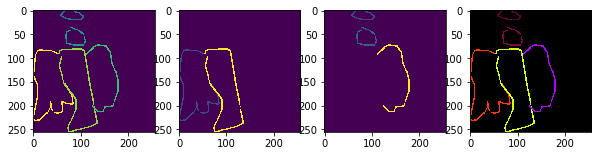

In [616]:
%%time
stroke = train.loc[ train.num_strokes ==  5, 'drawing'].values[3]
for i in range(1):
    img = draw_cv2_parts_opt(stroke)

fig, axs = plt.subplots(1, 4, figsize = (10, 10))
axs[0].imshow(img[...,0])
axs[1].imshow(img[...,1])
axs[2].imshow(img[...,2])
axs[3].imshow(img)

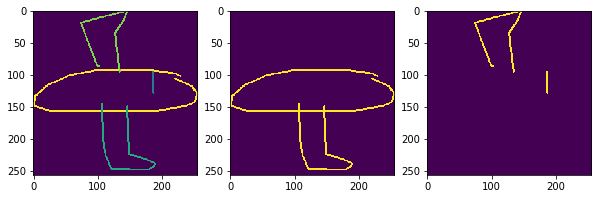

In [437]:
stroke = train.loc[ train.num_strokes == 4, 'drawing'].values[12]
# img = draw_cv2(stroke)

fig, axs = plt.subplots(1, 3, figsize = (10, 10))
axs[0].imshow(draw_cv2(stroke))

lengths = [get_line_length(s) for s in stroke]
median_length = np.mean(np.array(lengths))
point_cnts = [len(s[0]) for s in stroke]


linethresd = median_length

outlines = []
details = []
for s in stroke:
    if get_line_length(s) < linethresd or len(s[0]) < 3:
        details.append(s)
    else:
        outlines.append(s)

axs[1].imshow(draw_cv2(outlines, time_color = False))
if len(details) > 0:
    axs[2].imshow(draw_cv2(details, time_color = False))
else:
    axs[2].imshow(draw_cv2(stroke))
# axs[3].imshow(img)

In [122]:
outline_thresh = 2
ss = [s for s in stroke if len(s[0]) > outline_thresh]
# ss = [s for s in stroke if len(s[0]) < 10]

In [162]:
def get_line_length(stroke):
    length = 0
    for i in range(len(stroke) - 1):
        x = stroke[0][i + 1] - stroke[0][i]
        y = stroke[1][i + 1] - stroke[1][i]
        length += (x**2 + y**2) **(1/2)
    return length

In [184]:
tmp = stroke[0:1]

In [189]:
tmp

[[[57, 60, 63, 63, 68, 102, 110, 107], [116, 119, 105, 3, 0, 0, 54, 125]]]

In [193]:
def get_line_length(stroke):
    length = 0
    for i in range(len(stroke[0]) - 1):
        x = stroke[0][i + 1] - stroke[0][i]
        y = stroke[1][i + 1] - stroke[1][i]
        step_length = (x**2 + y**2) **(1/2)
#         print(step_length)
        length += step_length
    return int(length)

In [194]:
get_line_length(tmp[0])

286

In [160]:
get_line_length(stroke[1])

29

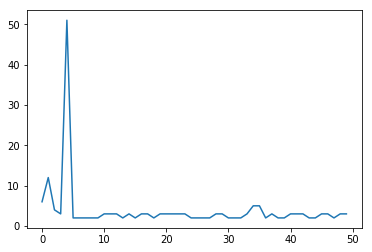

In [120]:
plt.plot([len(s[0]) for s in stroke])

183 0.44642857142857145 286
84 0.44642857142857145 63
239 0.44642857142857145 412
55 0.44642857142857145 0
55 0.44642857142857145 0
58 0.44642857142857145 5
58 0.44642857142857145 6
57 0.44642857142857145 3
56 0.44642857142857145 1
56 0.44642857142857145 1
57 0.44642857142857145 4
68 0.44642857142857145 28
55 0.44642857142857145 0
57 0.44642857142857145 3
60 0.44642857142857145 10
56 0.44642857142857145 1
75 0.44642857142857145 43
59 0.44642857142857145 8
68 0.44642857142857145 28
62 0.44642857142857145 15
255 0.44642857142857145 448
61 0.44642857142857145 13
64 0.44642857142857145 19
56 0.44642857142857145 2
57 0.44642857142857145 3
65 0.44642857142857145 21
55 0.44642857142857145 0
123 0.44642857142857145 151
74 0.44642857142857145 41
207 0.44642857142857145 339


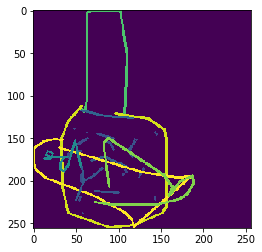

In [197]:
img = draw_cv2_linelength(stroke)
plt.imshow(img)